## Econometrics Week7

### William Schill

__Final Assignement. Developed in Python and code hidden with jupyterutils. Code version can be submitted as well.__

__Each portion is separated into "PART X" and the reponses are in bold below the hidden or unhidden code portions.__

In [1]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import *
import statsmodels.api as sma
import statsmodels.stats as sms
import statsmodels.tsa.stattools as smts
import statsmodels.discrete.discrete_model as sdd
import seaborn as sns
import sklearn as skl
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

C:\Python\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [2]:
from dfast.jupyterutils.togglecode import hideCode
hideCode()

ModuleNotFoundError: No module named 'dfast'

Bring in the data and check it out. Then fully shift (lag) the data for future use and print to confirm.

In [3]:
path = ''
df = pd.read_excel(path+'data.xls', index_col=0)
df.head(3)

,GDP,GDPIMPR,LOGGDP,GrowthRate,li1,li2,T
Date,,,,,,,
1950Q1,94.300,NaN,4.546481,NaN,0,0,0
1950Q2,95.200,1.0,4.555980,0.009499,0,0,1
1950Q3,97.663,1.0,4.581523,0.025543,3,1,2


In [4]:
## FULLY SHIFT AND LAG THE DATA SET HERE
full = pd.concat([df, df.shift(1), df.shift(2)], axis=1, join='outer')
cols = []
for lg in range(0,3):
    for i in df.columns:
        if lg==0:
            cols.append(i)
        else:
            cols.append(i+'(-'+str(lg)+')')

full.columns = cols

Fully lagged dataframe of variables.

In [5]:
print(full.head(3))

           GDP  GDPIMPR    LOGGDP  GrowthRate  li1  li2  T  GDP(-1)  \
Date                                                                  
1950Q1  94.300      NaN  4.546481         NaN    0    0  0      NaN   
1950Q2  95.200      1.0  4.555980    0.009499    0    0  1     94.3   
1950Q3  97.663      1.0  4.581523    0.025543    3    1  2     95.2   

        GDPIMPR(-1)  LOGGDP(-1)  ...    li1(-1)  li2(-1)  T(-1)  GDP(-2)  \
Date                             ...                                       
1950Q1          NaN         NaN  ...        NaN      NaN    NaN      NaN   
1950Q2          NaN    4.546481  ...        0.0      0.0    0.0      NaN   
1950Q3          1.0    4.555980  ...        0.0      0.0    1.0     94.3   

        GDPIMPR(-2)  LOGGDP(-2)  GrowthRate(-2)  li1(-2)  li2(-2)  T(-2)  
Date                                                                      
1950Q1          NaN         NaN             NaN      NaN      NaN    NaN  
1950Q2          NaN         NaN       

### PART A - Logliklihood Ratio Test

In [6]:
try:
    del x, y
except:
    pass

start = '1951Q1'
end = '2010Q4'

x = full[['li1(-1)','li2(-1)']]
xA = x[(x.index>=start)&(x.index<=end)]

y = full[['GDPIMPR']]
yA = y[(y.index>=start)&(y.index<=end)]

modA = sma.Logit(endog=yA, exog=sma.add_constant(xA))
fitA = modA.fit()
print(fitA.summary2())

Optimization terminated successfully.
         Current function value: 0.559076
         Iterations 5
                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.122     
Dependent Variable: GDPIMPR          AIC:              274.3565  
Date:               2017-12-17 12:57 BIC:              284.7984  
No. Observations:   240              Log-Likelihood:   -134.18   
Df Model:           2                LL-Null:          -152.76   
Df Residuals:       237              LLR p-value:      8.4833e-09
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     5.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.7288     0.1536    4.7454   0.0000    0.4278    1.0298
li1(-1)   -0.3719     0.0727   -5.1176   0.0000   -0.5143 

In [7]:
fitA_Cli1 =  sma.Logit(endog=yA, exog=sma.add_constant(xA[['li1(-1)']])).fit()
fitA_Cli2 =  sma.Logit(endog=yA, exog=sma.add_constant(xA[['li2(-1)']])).fit()

Optimization terminated successfully.
         Current function value: 0.582277
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.623002
         Iterations 5


Build the model from the data and match with the output on the test. Set up each specific model fit.

In [8]:
loglikA = np.reshape(np.array([fitA.llnull, fitA_Cli1.llf, fitA_Cli2.llf, fitA.llf]), (4,1))

loglik = np.reshape(np.array([-152.763, -139.747, -149.521, -134.178]), (4,1))
lldf = pd.DataFrame(loglik, index=['Const','Const+li1','Const+li2','All'], columns=['Loglikelihood'])

In [9]:
print("The loglikelihood estimations are below. \n ")
print("Loglikelihood:\n",  loglikA)
# print "Loglikelihood:\n", "\n", loglik, "\n \n LL Calc\n", loglikA

The loglikelihood estimations are below. 
 
Loglikelihood:
 [[-152.76340039]
 [-139.74657981]
 [-149.52046643]
 [-134.17823347]]


In [10]:
from scipy.stats import chisqprob
def likelihood_ratio(llmin, llmax):
    return(2.0*(llmax-llmin))

LR = np.zeros((len(loglikA),len(loglikA)))
dof = LR.copy()
for i in range(4):
    for j in range(4):
        LR[i,j] = likelihood_ratio(loglikA[i],loglikA[j])
        if i==j:
            dof[i,j] = 0
        elif np.abs(j-i)<3:
            dof[i,j] = 1
        else:
            dof[i,j] = 2
            
# p = np.around(chisqprob(LR, dof), 3) # L2 has 1 DoF more than L1
p = np.around(chisqprob(LR, dof), 5)
pF = np.reshape(p[0,1:], (1,3))

print("P-Values for Loglikelihood Comparisons of Model \n")
pd.DataFrame(pF, columns = ['Const+li1','Const+li2','All Params'], 
                   index = ['vs Null'])


P-Values for Loglikelihood Comparisons of Model 



,Const+li1,Const+li2,All Params
vs Null,0.0,0.01087,0.0


__(a)__:

__The matrix above reflects that the model is valid as all of the p-values are significant to thw 1% level with the Constant and li2 model being significant to the 5% level.__

__Additionally, this can be confirmed by examing the llr_pvalue features of the statsmodels models as seen below:__


In [11]:
lrsma = np.array([fitA_Cli1.llr_pvalue, fitA_Cli2.llr_pvalue, fitA.llr_pvalue],ndmin=2)
lrsm = pd.DataFrame(lrsma.T, columns=['Likelihood Ratio P-Values'])
lrsm.index = ['Const+li1','Const+li2','Full Model']
np.around(lrsm, 7)

,Likelihood Ratio P-Values
Const+li1,3.000000e-07
Const+li2,1.087350e-02
Full Model,0.000000e+00


### PART B

The cacluation for Mcfadden's is : Mcfaddens R^2 = 1 - LL_Model/LL_Null.


In [12]:
x = full[['li1(-1)','li2(-1)','li1(-2)','li2(-2)']]
xB = x[(x.index>=start)&(x.index<=end)]

y = full[['GDPIMPR']]
yB = y[(y.index>=start)&(y.index<=end)]

modB = sma.Logit(endog=yB, exog=sma.add_constant(xB))
fitB = modB.fit()

fitB_Cl11l21 =  sma.Logit(endog=yB, exog=sma.add_constant(xB[['li1(-1)','li2(-1)']])).fit()
fitB_Cl11l22 =  sma.Logit(endog=yB, exog=sma.add_constant(xB[['li1(-1)','li2(-2)']])).fit()
fitB_Cl12l21 =  sma.Logit(endog=yB, exog=sma.add_constant(xB[['li1(-2)','li2(-1)']])).fit()
fitB_Cl12l22 =  sma.Logit(endog=yB, exog=sma.add_constant(xB[['li1(-2)','li2(-2)']])).fit()

## Doing it this way left us with different results than expected.

Optimization terminated successfully.
         Current function value: 0.540830
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.559076
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.558860
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.543106
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.543588
         Iterations 6


In [13]:
LL_null = -152.763
LL_cl11l21 = -134.178
LL_cl11l22 = -134.126
LL_cl12l21 = -130.346
LL_cl12l22 = -130.461

LLB = pd.DataFrame(np.reshape(np.array([-152.763, -134.178, -134.126, -130.346, -130.461]),(1,5)))
LLB.columns = ['LL_null','LL_cl11l21','LL_cl11l22','LL_cl12l21','LL_cl12l22']


MR2 = pd.DataFrame(np.reshape(np.array([1.0 - LLB['LL_cl11l21']/LLB['LL_null'], 
                                        1.0 - LLB['LL_cl11l22']/LLB['LL_null'],
                                       1.0 - LLB['LL_cl12l21']/LLB['LL_null'],
                                       1.0 - LLB['LL_cl12l22']/LLB['LL_null']]),(1,4)))
MR2.columns = ['LL_cl11l21','LL_cl11l22','LL_cl12l21','LL_cl12l22']

print("Log Likelihoods : \n", LLB)
print("\n McFaddens R Squared : \n", MR2)

Log Likelihoods : 
    LL_null  LL_cl11l21  LL_cl11l22  LL_cl12l21  LL_cl12l22
0 -152.763    -134.178    -134.126    -130.346    -130.461

 McFaddens R Squared : 
    LL_cl11l21  LL_cl11l22  LL_cl12l21  LL_cl12l22
0    0.121659    0.121999    0.146744    0.145991


__(b)__:

__Based on the calculated McFaddens R^2 above, the most optimal model would be to go with the $Constant + li1(-2) + li2(-1)$ model. But not by very much.__

### PART C

Probability of economic growth over evaluation sample.

In [14]:
## The model was created above:
## It should be noted that they do not accurately specify the time constraints for these models!!!!!
print(fitB_Cl12l21.summary2())

                         Results: Logit
Model:              Logit            Pseudo R-squared: 0.147     
Dependent Variable: GDPIMPR          AIC:              266.6909  
Date:               2017-12-17 12:58 BIC:              277.1328  
No. Observations:   240              Log-Likelihood:   -130.35   
Df Model:           2                LL-Null:          -152.76   
Df Residuals:       237              LLR p-value:      1.8366e-10
Converged:          1.0000           Scale:            1.0000    
No. Iterations:     6.0000                                       
-------------------------------------------------------------------
           Coef.    Std.Err.      z      P>|z|     [0.025    0.975]
-------------------------------------------------------------------
const      0.7457     0.1573    4.7397   0.0000    0.4373    1.0540
li1(-2)   -0.4287     0.0763   -5.6175   0.0000   -0.5783   -0.2791
li2(-1)   -0.1312     0.0386   -3.3994   0.0007   -0.2068   -0.0556



In [15]:
x = full[['li1(-2)','li2(-1)']]
xC = x[x.index>end]

predC = fitB_Cl12l21.predict(sma.add_constant(xC))
predCTable = fitB_Cl12l21.pred_table(threshold=0.5)
rtot = np.sum(predCTable,axis=1)
tot = np.sum(rtot)

predCPRT = pd.DataFrame(predCTable/tot)
predCPRT.columns = ['yhat=0','yhat=1']
predCPRT.index = ['y=0','y=1']

predSum = pd.DataFrame(rtot)
predSum.columns=['Sum']
predSum.index = ['y=0','y=1']
prt = pd.concat([predCPRT, predSum], axis=1, join='outer')


print("Prediction Realization Table: \n")
print(prt, "\n")
print("Sums :")
print(np.sum(prt,axis=0), "\n")
print("Hit Rate :")
print(prt.iloc[0,0] + prt.iloc[1,1])

Prediction Realization Table: 

       yhat=0  yhat=1    Sum
y=0  0.133333  0.2000   80.0
y=1  0.104167  0.5625  160.0 

Sums :
yhat=0      0.2375
yhat=1      0.7625
Sum       240.0000
dtype: float64 

Hit Rate :
0.695833333333


__(c): THE PREDICTION REALIZATION TABLE AND HIT RATE ARE PRINTED ABOVE.__

__The hit rate is $69.58%$ and the probability of economic growth is approximately $76.25%$ in total.__

__The hit rate represents the accuracy of the model. With 1 being that the model is increasing we are likely to continue to see economic growth.__

### PART D

ADF Test for Log GDP. The ADF test is formulated and in Python you can print out the model results as seen below.

In [16]:
x = full[['LOGGDP']]
xD = x[(x.index>=start)&(x.index<=end)]

loggdp_ADF = sma.tsa.stattools.adfuller(xD['LOGGDP'], maxlag=1, 
                                        autolag=None, regression='ct',
                                        regresults=True) #c for constant only, no trend
print('ADF Test \n')
print('Statistic :', loggdp_ADF[0], ',  P-value :', loggdp_ADF[1],'\n')
print('Confidence Levels :', loggdp_ADF[2], '\n')
print('Model \n')
print(loggdp_ADF[3].resols.summary2(xname=['LOG GDP lag1','Diff LOG GDP lag1','Constant','Trend']))
### CONFIRMED THE ORDER OF CONST TREND

ADF Test 

Statistic : -2.51821089277 ,  P-value : 0.318918118591 

Confidence Levels : {'1%': -3.9973200578432064, '5%': -3.4290999471622556, '10%': -3.1379848180498104} 

Model 

                  Results: Ordinary least squares
Model:              OLS              Adj. R-squared:     0.393     
Dependent Variable: y                AIC:                -1888.3395
Date:               2017-12-17 12:58 BIC:                -1874.4504
No. Observations:   238              Log-Likelihood:     948.17    
Df Model:           3                F-statistic:        52.20     
Df Residuals:       234              Prob (F-statistic): 7.23e-26  
R-squared:          0.401            Scale:              2.0630e-05
-------------------------------------------------------------------
                     Coef.  Std.Err.    t    P>|t|   [0.025  0.975]
-------------------------------------------------------------------
LOG GDP lag1        -0.0204   0.0081 -2.5182 0.0125 -0.0364 -0.0044
Diff LOG GDP lag1    

__(d)__:

__The coefficient value for LOG GDP at 1 Lag is $-0.0204 $ and the subsequent p-value is $0.0125 $ which is significant to the 5% level. I do not think this is a necessary statistic to point out but it was in previous tests.__

__Based on the output listed above using the statsmodels ADF test, the test statistic is $-2.518 $ and its corresponding p-value is $0.3189 $. It is very far right of even the 10% confidence level and would thus imply that we cannot reject H0 and the variable is NOT stationary.__

### PART E

Modeling the Growth Rate at 1 Lag with varying lags of the First and Second Leading Indicators. Only the R Squares from the models are presented.

In [17]:
x1 = full[['GrowthRate(-1)','li1(-1)','li2(-1)']]
x11 = x1[(x1.index>=start)&(x1.index<=end)]

x2 = full[['GrowthRate(-1)','li1(-2)','li2(-1)']]
x12 = x2[(x2.index>=start)&(x2.index<=end)]

x3 = full[['GrowthRate(-1)','li1(-1)','li2(-2)']]
x21 = x3[(x3.index>=start)&(x3.index<=end)]

x4 = full[['GrowthRate(-1)','li1(-2)','li2(-2)']]
x22 = x4[(x4.index>=start)&(x4.index<=end)]

y1 = full[['GrowthRate']]
y11 = y1[(y1.index>=start)&(y1.index<=end)]
y12 = y11.copy()
y21 = y11.copy()
y22 = y11.copy()

modE11 = sma.OLS(endog=y11, exog=sma.add_constant(x11)).fit()
modE12 = sma.OLS(endog=y12, exog=sma.add_constant(x12)).fit()
modE21 = sma.OLS(endog=y21, exog=sma.add_constant(x21)).fit()
modE22 = sma.OLS(endog=y22, exog=sma.add_constant(x22)).fit()

r2 = pd.DataFrame([modE11.rsquared, modE12.rsquared, modE21.rsquared, modE22.rsquared])
r2.index = ['mod11','mod12','mod21','mod22']
r2.columns = ['R Squares']
r2

,R Squares
mod11,0.507975
mod12,0.477193
mod21,0.507665
mod22,0.477130


In [18]:
modE11Coefs = pd.DataFrame(modE11.params, 
                           columns=['Coefficients of Model k1=k2=1'])
modE11Coefs

,Coefficients of Model k1=k2=1
const,0.001737
GrowthRate(-1),0.461579
li1(-1),-0.001023
li2(-1),-0.000149


__(e)__:

__The results above show the best R2 is indeed $0.5079 $ for the model where $ k1 = k2 = 1 $  ( Mod11 ) barely beating out Mod21. The coefficients are then listed below that where the Growth Rate lagged variable has a coefficient of $ 0.461579 $. Such a large value in comparison to the other coefficients might indicate that we have a mispecification in our model.__

### PART F

Breusch Godfrey Test to examine the lag structure and see if the model was misspecified.

In [19]:
bgall = sms.diagnostic.acorr_breush_godfrey(modE11, nlags=1, store=True)
bg = bgall[0:4]
modE11_BG = pd.DataFrame(np.reshape(np.array(bg),(1,4)), 
                         columns=['LM Stat','LM p-val','Fvalue','Fval:p-val'],
                        index=['BG Test for Model k1=k2=1'])
modE11_BG

,LM Stat,LM p-val,Fvalue,Fval:p-val
BG Test for Model k1=k2=1,0.230366,0.631253,0.225783,0.63511


__(f)__:

__The Breusch Godfrey test for the model where $ k1=k2=1 $ at 1 Lag shows a high p-value for the test statistic of $ 0.230366 $. This test has H0 that there is no serial correlation and with a low p-value we reject the Null. Thus with a p-value of $ 0.631253 $ we cannot reject the null and there is no serial correlation.__

### PART G

Forecast for the Growth Rate.

In [20]:
x = full[['GrowthRate(-1)','li1(-1)','li2(-1)']]
xG = x[x.index>end]
xGR = pd.DataFrame(full[full.index>end]['GrowthRate'])

predG = modE11.predict(sma.add_constant(xG))

predGdf = pd.DataFrame(predG, index=xG.index)
outDf = pd.concat([predGdf, xGR], axis=1, join='outer')
outDf.columns = ['Prediction','Actual']

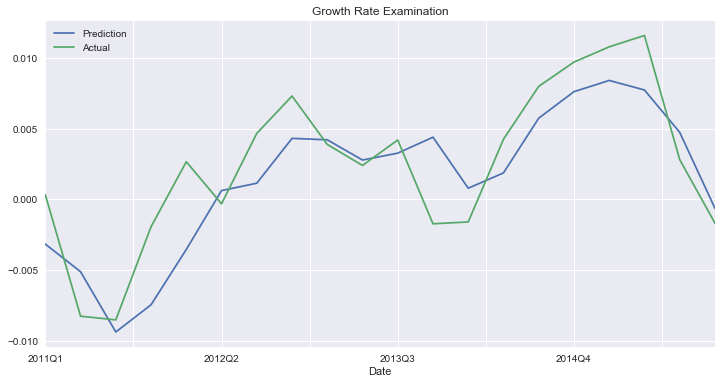

In [21]:
fig2, ax=subplots(1,1,figsize=(12,6))
outDf.plot(ax=ax, title='Growth Rate Examination')

In [23]:
maeG = np.sum(np.absolute(predGdf.values-xGR.values))
rmseG = np.sqrt(((predGdf.values-xGR.values) ** 2).mean())
print( "FIT G  :  RMSE  \  MAE  = ", rmseG, "  \  ", maeG, "\n")

FIT G  :  RMSE  \  MAE  =  0.00315576342885   \   0.0528065895385 



__(g)__:

__The above is the time series representation of the prediction and actuals over the 'evaluation' period. The RMSE is $ 0.003156 $ and the MAE is $ 0.0528 $.__

__The prediction is significantly smoother than the actuals which is to be expected and based on appearance and error the prediction model fits the actuals very well.__

In [72]:
from dfast.jupyterutils.togglecode import hideCode
hideCode()